In [1]:
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import gym
import cntk
from cntk import *
from cntk.layers import *
%matplotlib inline

In [2]:
class ReplayBuffer: 
    """
    Fixed capacity buffer implemented as circular queue
    Transitions are stored as (s, a, r, s', done) tuples
    """
    def __init__(self, capacity):
        self.samples = np.ndarray(capacity, dtype=object)
        self.capacity = capacity
        self.counter = 0
        self.flag = False
        
    def size(self):
        if self.flag:
            return self.capacity
        else:
            return self.counter
        
    def add(self, sample):
        self.samples[self.counter] = sample
        
        self.counter += 1
        if self.counter >= self.capacity:
            self.counter = 0
            self.flag = True
            
    def sample(self, n):
        n = min(n, self.size())
        
        size = self.size()
        if size < self.capacity:
            return np.random.choice(self.samples[:size], n, replace=False)
        else:
            return np.random.choice(self.samples, n, replace=False)

In [3]:
class Agent:
    def __init__(self, state_dim, action_dim, learning_rate):
        self.state_dim = state_dim
        self.action_dim = action_dim
        self.learning_rate = learning_rate
        self.epsilon = 1
        
        # Create the model and set up trainer
        self.state_var = input(self.state_dim, np.float32)
        self.action_var = input(self.action_dim, np.float32)
        
        self.online_model = Sequential([
            Dense(64, activation=relu),
            Dense(self.action_dim)
        ])(self.state_var)

        loss = reduce_mean(square(self.online_model - self.action_var), axis=0)
        lr_schedule = learning_rate_schedule(self.learning_rate, UnitType.sample)
        learner = sgd(self.online_model.parameters, lr_schedule)
        self.trainer = Trainer(self.online_model, loss, learner)
        
        # Create target network and initialize with same weights
        self.target_model = None
        self.update_target()
    
    def update_target(self):
        """
        Updates the target network using the online network weights
        """
        self.target_model = self.online_model.clone(CloneMethod.clone)
        
    def update_epsilon(self, episode):
        """
        Updates epsilon using exponential decay with the decay rate chosen such
        that epsilon is 0.05 by episode 8000
        """
        self.epsilon = max(math.exp(-3.74e-4 * episode), 0.05)
        
    def predict(self, s, target=False):
        """
        Feeds a state through the model (our network) and obtains the values of each action
        """
        if target:
            return self.target_model.eval(s)
        else:
            return self.online_model.eval(s)
        
    def act(self, state):
        """
        Selects an action using the epoch-greedy approach
        """
        prob = np.random.randn(1)
        if prob > self.epsilon:
            # exploit (greedy)
            return np.argmax(self.predict(state))
        else:
            # explore (random action)
            return np.random.randint(0, self.action_dim)
        
    def train(self, x, y):
        """
        Performs a single gradient descent step using the provided states and targets
        """
        self.trainer.train_minibatch({self.state_var: x, self.action_var: y})
        
    def evaluate(self, env, n):
        """
        Computes the average performance of the trained model over n episodes
        """
        episode = 0
        rewards = 0
        while episode < n:
            s = env.reset()
            done = False
            while not done:
                a = np.argmax(self.predict(s.astype(np.float32)))
                s, r, done, info = env.step(a)
                rewards += r
            episode += 1
            
        return rewards / float(n)

In [4]:
def initialize_buffer(env, buffer):
    """
    Initializes the replay buffer using experiences generated by taking random actions
    """
    actions = env.action_space.n
    s = env.reset()
    
    while buffer.size() < buffer.capacity:
        a = np.random.randint(0, actions)
        s_, r, done, info = env.step(a)
        
        buffer.add((s, a, r, s_, done))
        
        if done:
            s = env.reset()
        else:
            s = s_

In [5]:
def train(env, agent, buffer, episodes, gamma, minibatch_size, update_freq):
    """
    param env: The gym environment to train with
    param agent: The agent to train
    param buffer: The replay buffer to sample experiences from
    param episodes: The number of episodes to train for
    param gamma: The discount factor
    param minibatch_size: The number of transitions to sample for 
    param update_freq: The frequency at which to update the target network
    """
    episode = 0
    rewards = 0
    log_freq = 200
    episode_rewards = []
    s = env.reset().astype(np.float32)
    
    while episode < episodes:
        # Select an action using policy derived from Q (e-greedy)
        a = agent.act(s)
        
        # Take action and observe the next state and reward
        s_, r, done, info = env.step(a)
        s_ = s_.astype(np.float32)
        
        # Store transition in replay buffer
        buffer.add((s, a, r, s_, done))
        
        s = s_
        rewards += r
        
        # Sample random transitions from replay buffer
        batch = buffer.sample(minibatch_size)
        
        # Compute targets, y_i
        states = np.array([obs[0] for obs in batch], dtype=np.float32)
        states_ = np.array([obs[3] for obs in batch], dtype=np.float32)
        
        y = agent.predict(states)
        q_next = agent.predict(states_, target=True)
        
        for i in range(minibatch_size):
            p, a, r, p_, d = batch[i]
            if d:
                y[i, a] = r
            else:
                y[i, a] = r + gamma * np.amax(q_next[i])
        
        # Train using state and computed target
        agent.train(states, y)
        
        if done:
            # Episode over, reset environment
            episode_rewards.append(rewards)
            rewards = 0
            
            episode += 1
            agent.update_epsilon(episode)
            s = env.reset().astype(np.float32)
            
            if episode % log_freq == 0:
                ave = sum(episode_rewards[(episode - log_freq):]) / float(log_freq)
                print('Episode = {}, Average rewards = {}'.format(episode, ave))
                
            if episode % update_freq == 0:
                agent.update_target()                
                
    return episode_rewards

In [6]:
gamma = 0.60
learning_rate = 0.00025
episodes = 10000
buffer_capacity = 32
minibatch_size = 8
update_freq = 500

In [7]:
env = gym.make('CartPole-v0')
state_dim = env.observation_space.shape
action_dim = env.action_space.n

[2017-04-21 17:48:29,518] Making new env: CartPole-v0


In [8]:
buffer = ReplayBuffer(buffer_capacity)
agent = Agent(state_dim, action_dim, learning_rate)

In [9]:
initialize_buffer(env, buffer)
rewards = train(env, agent, buffer, episodes, gamma, minibatch_size, update_freq)

Episode = 200, Average rewards = 18.995
Episode = 400, Average rewards = 16.995
Episode = 600, Average rewards = 18.4
Episode = 800, Average rewards = 19.04
Episode = 1000, Average rewards = 17.355
Episode = 1200, Average rewards = 23.22
Episode = 1400, Average rewards = 23.31
Episode = 1600, Average rewards = 28.69
Episode = 1800, Average rewards = 27.785
Episode = 2000, Average rewards = 32.77
Episode = 2200, Average rewards = 37.565
Episode = 2400, Average rewards = 36.82
Episode = 2600, Average rewards = 35.18
Episode = 2800, Average rewards = 44.275
Episode = 3000, Average rewards = 42.825
Episode = 3200, Average rewards = 46.71
Episode = 3400, Average rewards = 48.855
Episode = 3600, Average rewards = 49.82
Episode = 3800, Average rewards = 54.215
Episode = 4000, Average rewards = 56.105
Episode = 4200, Average rewards = 54.695
Episode = 4400, Average rewards = 59.79
Episode = 4600, Average rewards = 62.535
Episode = 4800, Average rewards = 65.265
Episode = 5000, Average rewards 

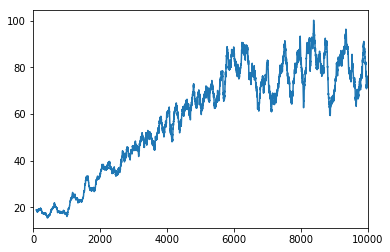

In [10]:
pd.Series(rewards).rolling(window=100).mean().plot()
plt.show()

In [11]:
eval_episodes = 100
ave = agent.evaluate(env, eval_episodes)

print('DQN Average performance = {}'.format(ave))

DQN Average performance = 190.65


In [12]:
agent.online_model.save_model('cart_pole.dqn')

In [17]:
# Load saved model and evaluate
model = load_model('cart_pole.dqn')

s = env.reset()
done = False
while not done:
    env.render()
    a = np.argmax(model.eval(s.astype(np.float32)))
    s, r, done, info = env.step(a)

In [18]:
env.close()